# FORESEE Models: ALP coupling to gluons

## Load Libraries 

In [1]:
import numpy as np
import sys
import os
src_path = "../../"
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model
from matplotlib import pyplot as plt

/home/makelat/work/FORESEE/Models/ALP-g/../../src/foresee.py:563: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def boostlist(arr_particle, arr_boost):


## 1. Specifying the Model

The phenomenology of the ALP coupling to gluons can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = - \frac{1}{2} \color{red}{m_{a}}^2 a^2  - \frac{g_s^2}{8}\color{red}{g_{agg}}a G^a_{\mu\nu} \tilde G^a_{\mu\nu}
\end{equation}

with the ALP mass $m_a$ and the coupling parameter $g_{agg}$ as free parameters. 

In [2]:
energy = "13.6"
modelname="ALP-g"
model = Model(modelname)

**Production** The ALP is produced in the FCNC B-meson decays. The branching fractions are (with $g = g_{agg}\cdot GeV$)

\begin{equation}
\text{BR}(B \to X_s a)     = 76 \times g^2 \times [(1-m_a^2/m_B^2)]^{2}
\end{equation}

In the following, we model heavy hadron production using the `POWHEG+Pythia8` predicions. We focus on $B^0$ and $B^+$ decays, which will provide the leading contribution. 

In [3]:
model.add_production_2bodydecay(
    pid0 = "511",
    pid1 = "130",
    br = "76 * coupling**2 * (1-(mass/self.masses('pid0'))**2)**2",
    generator = ['NLO-P8','NLO-P8-Max', 'NLO-P8-Min'],
    energy = energy,
    nsample = 100, 
) 

model.add_production_2bodydecay(
    pid0 = "-511",
    pid1 = "130",
    br = "76 * coupling**2 * (1-(mass/self.masses('pid0'))**2)**2",
    generator = ['NLO-P8','NLO-P8-Max', 'NLO-P8-Min'],
    energy = energy,
    nsample = 100, 
) 

model.add_production_2bodydecay(
    pid0 = "521",
    pid1 = "321",
    br = "76 * coupling**2 * (1-(mass/self.masses('pid0'))**2)**2",
    generator = ['NLO-P8','NLO-P8-Max', 'NLO-P8-Min'],
    energy = energy,
    nsample = 100, 
) 

model.add_production_2bodydecay(
    pid0 = "-521",
    pid1 = "-321",
    br = "76 * coupling**2 * (1-(mass/self.masses('pid0'))**2)**2",
    generator = ['NLO-P8','NLO-P8-Max', 'NLO-P8-Min'],
    energy = energy,
    nsample = 100, 
)        

We can also produce the ALP via its resonant mixing with the pseudo-scalar mesons, in particular the $\pi^0$, $\eta$ and $\eta '$ mesons. Following [2201.05170](https://arxiv.org/pdf/2201.05170.pdf), we can write 

\begin{equation}
\sigma(A') = \theta_P^2 \  \sigma(P)
\end{equation}

with 

\begin{equation}
\theta_{a\pi^0} =  (3.671) \, g \ \frac{(-0.180)m_a^2 }{m_a^2 - m_{\pi^0}^2}, \quad 
\theta_{a\eta} =  (3.671) \, g \ \frac{(-0.3596)m_a^2 + 0.0021 }{m_a^2 - m_{\eta}^2}, \quad
\theta_{a\eta '} =  (3.671) \, g \ \frac{(-0.3362)m_a^2 + 0.0092 }{m_a^2 - m_{\eta '}^2} .
\end{equation}

We model light hadron production using `EPOSLHC`, `SIBYLL`, `QGSJET` and `Pythia8-Forward`

In [4]:
model.add_production_mixing(
    pid = "111",
    mixing = "(3.671) * coupling * (-0.180 * mass**2)/(mass**2 - self.masses('pid')**2)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
)

model.add_production_mixing(
    pid = "221",
    mixing = "(3.671) * coupling * (-0.3596 * mass**2 + 0.0021)/(mass**2 - self.masses('pid')**2)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
)

model.add_production_mixing(
    pid = "331",
    mixing = "(3.671) * coupling * (-0.3362 * mass**2 + 0.0092)/(mass**2 - self.masses('pid')**2)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
)

**Decay** The ALP decays to 2 photons below the $3m_{\pi}$ threshold, and into 3$\pi$, 2$\pi\gamma$ states above it. Here we use the decay widths, lifetime and BR derived in [1811.03474](https://arxiv.org/abs/1811.03474) using the files provided in the [ALPINIST](https://github.com/jjerhot/ALPINIST) repository. 

In [5]:
model.set_ctau_1d(
    filename="model/ctau.txt",
)

decay_modes =  ["br_2Gamma", "br_3Pi0", "br_Pi+Pi-Gamma", "br_Pi+Pi-Pi0", "br_2PiEta"]     
model.set_br_1d(
    modes=decay_modes,
    finalstates=[[22,22], [111,111,111], [211,-211,22], [211,-211, 111], [211,-211,221]],
    filenames=["model/br/"+mode+".dat" for mode in decay_modes],
)

We can now initiate FORESEE with the model that we just created. 

In [6]:
foresee = Foresee(path=src_path)
foresee.set_model(model=model)

## 2. Event Generation

In the following, we want to study one specific benchmark point with $m_{a}=200$ MeV and $g= 5\cdot 10^{-4}$ and export events as a HEPMC file. 

In [7]:
mass, coupling, = 0.2, 5e-4

First, we will produce the corresponding flux for this mass and a reference coupling $\epsilon_{ref}=1$. 

save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Max_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Min_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Max_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Min_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Max_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Min_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Max_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Min_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.2.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.2.npy
save data

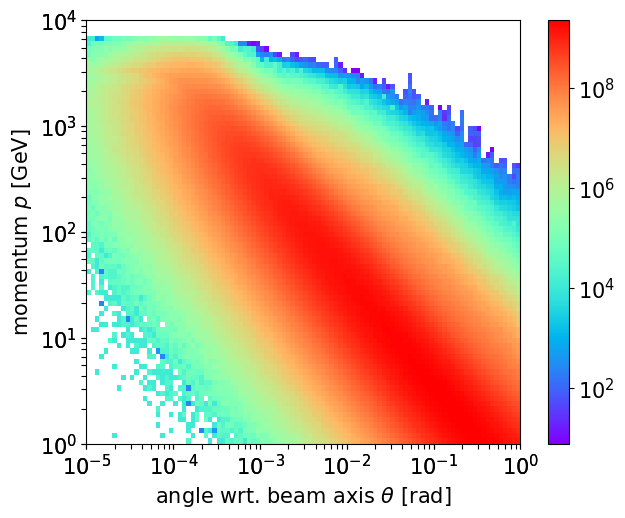

In [8]:
plot=foresee.get_llp_spectrum(mass=mass, coupling=1, do_plot=True)
plot.savefig("Spectrum_"+modelname+".pdf")
plot.show()

Next, let us define the configuration of the detector (in terms of position, size and luminosity). Here we choose FASER during 2022/2023 and require the decay channel $A' \to \gamma\gamma$ and $A' \to 3\pi^{0}$. 

In [9]:
foresee.set_detector(
    distance=474, 
    selection="np.sqrt(x.x**2 + (x.y+0.065)**2)<.1", 
    length=3.5, 
    luminosity=60, 
    channels=["br_2Gamma", "br_3Pi0"],
)

For our benchmark point, let us now look at how many particle decay inside the decay volume. We also export 1000 unweighted events as a HEPMC file. 

In [10]:
setupnames = ['EPOSLHC', 'SIBYLL', 'QGSJET','PYTHIA']
modes = {
         '111': ['EPOSLHC', 'SIBYLL'    , 'QGSJET'    ,'Pythia8-Forward'], 
         '221': ['EPOSLHC', 'SIBYLL'    , 'QGSJET'    ,'Pythia8-Forward'], 
         '331': ['EPOSLHC', 'SIBYLL'    , 'QGSJET'    ,'Pythia8-Forward'],   
} 

momenta, weights, _ = foresee.write_events(
    mass = mass, 
    coupling = coupling, 
    energy = energy, 
    numberevent = 1000,
    filename = "model/events/test.hepmc", 
    return_data = True,
    modes=modes,
    weightnames=setupnames,
    nsample=100,
)

for isetup, setup in enumerate(setupnames):
    print("Expected number of events for "+setup+":", round(sum(weights[:,isetup]),3))

Expected number of events for EPOSLHC: 2005.432
Expected number of events for SIBYLL: 2777.854
Expected number of events for QGSJET: 1206.976
Expected number of events for PYTHIA: 2066.772


Let us plot the resulting energy distribution

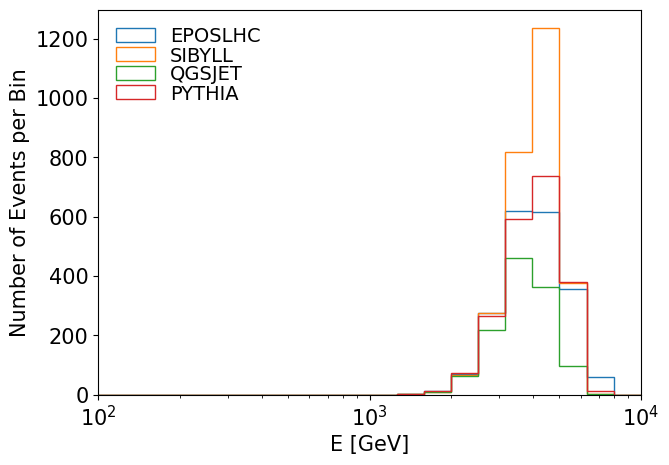

In [11]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
energies = [p.e for p in momenta], 
for isetup, setup in enumerate(setupnames):
    ax.hist(energies, weights=weights[:,isetup], bins=np.logspace(2,4, 20+1), histtype='step', label=setup) 
ax.set_xscale("log")
ax.set_xlim(1e2,1e4) 
ax.set_xlabel("E [GeV]") 
ax.set_ylabel("Number of Events per Bin") 
ax.legend(frameon=False, labelspacing=0, fontsize=14, loc='upper left')
plt.savefig("E_distribution_"+modelname+".pdf")
plt.show()

## 3. Sensitivity Reach

In the following, we will obtain the projected sensitivity for the LLP model. For this, we first define a grid of couplings and masses, and then produce the corresponding fluxes. 

In [12]:
masses=[round(x,5) for x in np.logspace(-2,0,41+1)]
couplings = np.logspace(-8,0,81)

for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Max_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Min_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Max_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Min_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Max_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Min_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Max_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Min_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.01

save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.01567.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.01567.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.01567.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_Pythia8-Forward_m_0.01567.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_0.01567.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_0.01567.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_0.01567.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_Pythia8-Forward_m_0.01567.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8_m_0.01753.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Max_m_0.01753.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Min_m_0.01753.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8_m_0.01753.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Max_m_0.01753.npy
save data to file: ./model/LLP

save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Max_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Min_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Max_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Min_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_Pythia8-Forward_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.02748.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.02748.npy
save data to file: ./model/LLP_spe

save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_0.04307.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_0.04307.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_0.04307.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_Pythia8-Forward_m_0.04307.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8_m_0.04819.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Max_m_0.04819.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Min_m_0.04819.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8_m_0.04819.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Max_m_0.04819.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Min_m_0.04819.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8_m_0.04819.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Max_m_0.04819.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Min_m_0.04819.npy
save data to file: ./model/

save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_Pythia8-Forward_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_Pythia8-Forward_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_Pythia8-Forward_m_0.07552.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8_m_0.08449.npy
save data to file: ./model/LLP_spe

save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Max_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Min_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Max_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Min_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Max_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Min_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.13242.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_Pythia8-Forward_m_0.13242.npy
save data to file: ./mod

save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_0.20753.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_0.20753.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_0.20753.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_Pythia8-Forward_m_0.20753.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Max_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8-Min_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Max_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Min_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Max_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Min_m_0.2322.npy
save data to file: ./model/LLP_spect

save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_Pythia8-Forward_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_Pythia8-Forward_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_Pythia8-Forward_m_0.36389.npy
save data to file: ./model/LLP_spectra/13.6TeV_511_NLO-P8_m_0.40715.npy
save data to file: ./model/LLP_spe

save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Max_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_-511_NLO-P8-Min_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Max_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_521_NLO-P8-Min_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Max_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_-521_NLO-P8-Min_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.63808.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_Pythia8-Forward_m_0.63808.npy
save data to file: ./mod

save data to file: ./model/LLP_spectra/13.6TeV_331_EPOSLHC_m_1.0.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_SIBYLL_m_1.0.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_QGSJET_m_1.0.npy
save data to file: ./model/LLP_spectra/13.6TeV_331_Pythia8-Forward_m_1.0.npy


We can now plot the `production rate vs mass` using the `foresee.plot_production()` function.

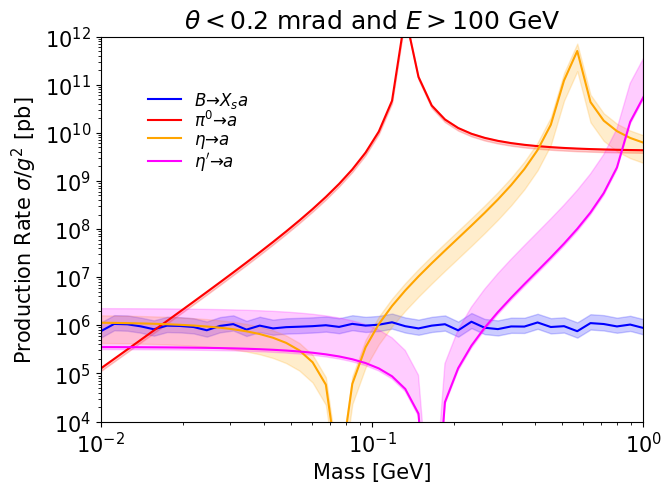

In [13]:
productions=[   
     {"channels": ["511","-511", "521","-521"],  "color": "blue", "label": r"$B \to X_s a $", "generators": ['NLO-P8','NLO-P8-Max', 'NLO-P8-Min']},    
     {"channels": ["111"], "color": "red"     , "label": r"$\pi^0\to a$" , "generators": ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward']},    
     {"channels": ["221"], "color": "orange"  , "label": r"$\eta\to a$"  , "generators": ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward']}, 
     {"channels": ["331"], "color": "magenta" , "label": r"$\eta'\to a$" , "generators": ['EPOSLHC', 'SIBYLL', 'Pythia8-Forward']},
]

plot=foresee.plot_production(
    masses = masses,
    productions = productions,
    energy=energy,
    condition="logth<-3.7 and logp>2",   
    xlims=[0.01,1], ylims=[1e4,1e12],     
    xlabel=r"Mass [GeV]",
    ylabel=r"Production Rate $\sigma/g^2$ [pb]",
    title=r"$\theta < 0.2$ mrad and $E > 100$ GeV",    
    legendloc=(0.3,0.9),
    fs_label=12,
    ncol=1,
)
plot.savefig("Production_"+modelname+".pdf")

Let us now scan over various masses and couplings, and record the resulting number of evets. Note that here we again consider the FASER configuration, which we set up before.

In [14]:
#get reach  
list_nevents = {label:[] for label in setupnames}
for mass in masses:
    couplings, _, nevents, _, _  = foresee.get_events(mass=mass, energy=energy, couplings = couplings,modes=modes,nsample=10)
    for i,label in enumerate(setupnames): list_nevents[label].append(nevents.T[i])  
        
#save results
configuration='default'
for label in setupnames: 
    result = np.array([masses,couplings,list_nevents[label]], dtype='object')
    np.save("model/results/"+energy+"TeV_"+configuration+"_"+label+".npy",result)

We can now plot the results. For this, we first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [15]:
setups = [ 
    ["13.6TeV_default_EPOSLHC.npy"        ,  "EPOSLHC"    , "red"           ,  "solid"  , 0., 3],
    ["13.6TeV_default_SIBYLL.npy"         ,  "SYBILL"     , "magenta"       ,  "solid"  , 0., 3],
    ["13.6TeV_default_QGSJET.npy"         ,  "QGSJET"     , "orange"        ,  "solid"  , 0., 3],
    ["13.6TeV_default_PYTHIA.npy"         ,  "PYTHIA"     , "salmon"        ,  "solid"  , 0., 3],      

]

Then we specify all the existing bounds, separating the bounds obtained by experimental collaboratios and theory recasts.

In [16]:
bounds = [   
#     ["bounds_1811.03474.txt"           ,    "flavor",   0.200, 1.5*10**-2, 0  ],   
     ["bounds_BaBar_2108.10331.txt"     ,    "Babar"                                  , 0.355, 1.5e-3, 90],  
     ["bounds_NA62_2311.01837.txt"      ,    "NA62"                                   , 0.230, 1.5e-3, 90],
     ["bounds_NA62_2311.01837.txt"      ,    r"$K^+\rightarrow\pi^+a(\gamma\gamma)$"  , 0.265, 1.5e-3, 90],    
     ["bounds_NA62_2103.15389.txt"      ,    "NA62"                                   , 2e-2 , 1e-4  , 0],
     ["bounds_NA62_2103.15389.txt"      ,    r"$K^+\rightarrow\pi^+X_{inv}$"          , 2e-2 , 6e-5  , 0],   
     ["bounds_NA62_2103.15389_2half.txt",    "NA62"                                   , 0.16 , 1.2e-6, 90],
     ["bounds_NA62_2103.15389_2half.txt",    r"$K^+\rightarrow\pi^+X_{inv}$"          , 0.19 , 1.2e-6, 90],    
     ["bounds_NA62_2010.07644.txt"      ,    "NA62"                                   , 0.08 , 1.5e-5, 90],
     ["bounds_NA62_2010.07644.txt"      ,    r"$\pi^0\rightarrow X_{inv}$"            , 0.09 , 1.5e-5, 90],    
     ["bounds_NA62_2010.07644_2half.txt",    ""                                       , 0.16 , 1.2e-6, 0],   
]

bounds2=[
    ["bounds_NuCal1.txt"     , "NuCal"        ,    0.275, 1.2*10**-6, 0   ],
    ["bounds_NuCal2.txt"     , ""             ,    4.000, 6.7*10**-4, 0   ],   
    ["bounds_NuCal3.txt"     , ""             ,    0.275, 1.2*10**-6, 0   ],
    ["bounds_Kwidth.txt"     , "$\Gamma_{K^+}$",   0.110, 5.2*10**-2, 0   ],
    ["bounds_E949.txt"       , "E949"         ,    0.020, 1.2*10**-2, 0   ],
    ["bounds_NA48.txt"       , "NA48"         ,    0.040, 1.2*10**-2, 0   ],
#    ["bounds_E137.txt"       , "E137" ,    4.000, 6.7*10**-4, 0   ],   
#    ["bounds_CHARM1.txt"     , "CHARM",    0.275, 1.2*10**-6, 0   ],
#    ["bounds_CHARM2.txt"     , ""     ,    4.000, 6.7*10**-4, 0   ],   
#    ["bounds_KOTO1.txt"      , "KOTO" ,    4.000, 6.7*10**-4, 0   ],   
#    ["bounds_KOTO2.txt"      , ""     ,    4.000, 6.7*10**-4, 0   ],     
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [17]:
projections=[
     ["limits_KOTO_2303.01521.txt"      ,   "teal",  "KOTO"    , 0.275, 1.3e-7, 0  ],   
     ["limits_KOTO_2303.01521_2half.txt",   "teal",  ""        , 0    , 0     , 0  ],   
     ["limits_SHADOWS1.txt"             ,   "cyan",  "SHADOWS" , 0.455, 0.8e-4, 0  ],   
     ["limits_SHADOWS2.txt"             ,   "cyan",  ""        , 0    , 0     , 0  ],
     ["limits_SHIP.txt"                 ,   "blue",  "SHIP"    , 0.555, 0.5e-4, 0  ],   
]

We also want to show the branching fractions for some of the channels (name of file in model/br directory, color, line style, label, x-position, y-position) 

In [18]:
branchings = [
    ["br_2Gamma"      , "black"        , "solid" , r"$\gamma\gamma$"         , 0.110, 0.50],
    ["br_3Pi0"        , "blue"         , "solid" , r"$\pi^0\pi^0\pi^0$"      , 0.235, 0.2 ], 
    ["br_Pi+Pi-Gamma" , "green"        , "solid" , r"$\pi^+\pi^-\gamma$"     , 0.235, 0.03],
    ["br_Pi+Pi-Pi0"   , "brown"        , "solid" , r"$\pi^+\pi^-\pi^0$"      , 0.235, 0.07],
    ["br_2PiEta"      , "red"          , "solid" , r"$\pi^+\pi^-\eta$"       , 0.6  , 0.75],    

]

Finally, we can plot everything using `foresee.plot_reach()`.

/home/makelat/work/FORESEE/Models/ALP-g/../../src/foresee.py:1241: RuntimeWarning: invalid value encountered in log10
  n = np.log10(np.array(nsignals).T+1e-20)


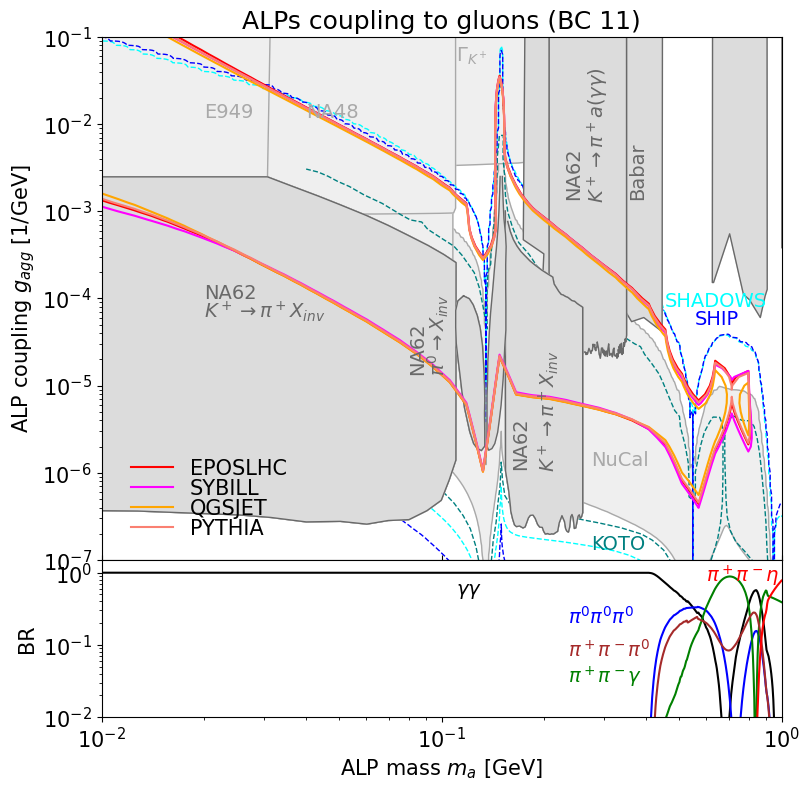

In [19]:
plot, ax, ax2 = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    bounds2=bounds2,
    projections=projections,
    title="ALPs coupling to gluons (BC 11)", 
    xlims = [0.01,1], 
    ylims=[10**-7,0.1],
    xlabel=r"ALP mass $m_{a}$ [GeV]", 
    ylabel=r"ALP coupling $g_{agg}$ [1/GeV]",
    legendloc=(0.3,0.23),
    branchings=branchings,
    figsize=(8,8),
)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("Reach_"+modelname+".pdf")
plot.show()